# CFDPyRun

This notebook consists of my run-through of Prof. Lorena Barba's CFDPython course. It is set in a "teacher first, student next" fashion, with the student developing the stock functions with his/her own ideas. The development is chronologically presented.

#### Python libraries

In [186]:
import numpy
import sympy
from sympy import init_printing
from sympy.utilities.lambdify import lambdify
from matplotlib import pyplot
import time, sys
from matplotlib import rc
from matplotlib import pyplot, cm
from sympy import init_printing
from mpl_toolkits.mplot3d import Axes3D 
init_printing(use_latex=True)
rc('font',**{'family':'serif'})
rc('text', usetex=True)

### Step 1: 1-D Linear Convection

Partial differential equation: $$ \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0 $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + c\frac{u^n_i - u^n_{i-1}}{\Delta x} = 0 $$`

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


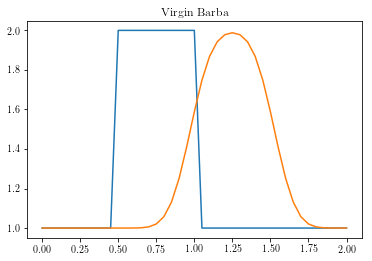

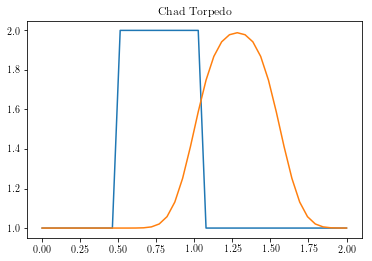

In [208]:
def linearconv(nx):
    dx = 2.0/(nx-1)
    nt = 20
    dt = 0.025
    c = 1.0

    u = numpy.ones(nx)
    u[int (.5/dx): int(1/dx + 1)] = 2.0
    print(u)

    pyplot.figure(1)
    pyplot.title('Virgin Barba')
    pyplot.plot(numpy.linspace(0,2,nx), u)

    for n in range(nt):
        un = u.copy()
        for i in range(1,nx):
            u[i] = un[i] - c*dt/dx*(un[i] - un[i-1])

    pyplot.plot(numpy.linspace(0,2,nx), u)

linearconv(41)

def linearConvection(nx):
    dx = 2.0/nx
    nt = 21
    dt = 0.025
    c = 1

    u = numpy.ones((nt,nx))
    u[0][int (.5/dx): int(1/dx +1)] = 2.0
    print(u[0])

    for n in range(nt-1):
        for i in range(1,nx):
            u[n+1][i] = u[n][i] - c*dt/dx*(u[n][i] - u[n][i-1])
    
    pyplot.figure(2)
    pyplot.title('Chad Torpedo')
    pyplot.plot(numpy.linspace(0,2,nx), u[0], numpy.linspace(0,2,nx), u[nt-1])

linearConvection(40)

### Step 2: 1-D Nonlinear Convection

Partial differential equation: $$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0 $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + u^n_i\frac{u^n_i - u^n_{i-1}}{\Delta x} = 0 $$

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


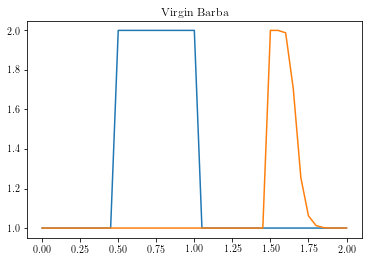

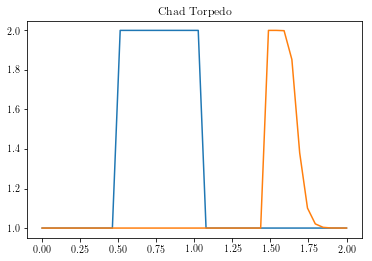

In [209]:
def nonlinearconv(nx):
    dx = 2.0/(nx-1)
    nt = 20
    dt = 0.025

    u = numpy.ones(nx)
    u[int (.5/dx): int(1/dx + 1)] = 2.0
    print(u)

    pyplot.figure(1)
    pyplot.title('Virgin Barba')
    pyplot.plot(numpy.linspace(0,2,nx), u)
    
    for n in range(nt):
        un = u.copy()
        for i in range(1,nx):
            u[i] = un[i]*(1 - dt/dx*(un[i] - un[i-1]))

    pyplot.plot(numpy.linspace(0,2,nx), u)

nonlinearconv(41)

def nonLinearConvection(nx):
    dx = 2.0/nx
    nt = 20
    dt = 0.025
    
    u = numpy.ones((nt,nx))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0
    print(u[0])

    for n in range(nt-1):
        for i in range(1,nx):
            u[n+1][i] = u[n][i]*(1 - dt/dx*(u[n][i] - u[n][i-1]))
            
    pyplot.figure(2)
    pyplot.title('Chad Torpedo')
    pyplot.plot(numpy.linspace(0,2,nx), u[0], numpy.linspace(0,2,nx), u[nt-1])

nonLinearConvection(40)

### Investigation: CFL Condition

Courant number: $$ \sigma = \frac{u\Delta t}{\Delta x} \leq \sigma_{\max} $$

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


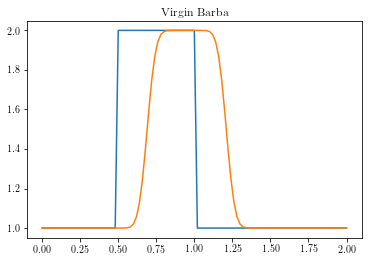

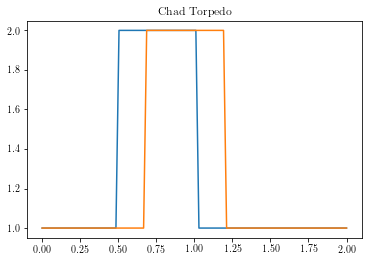

In [210]:
def linearconvCFL(nx):
    dx = 2.0/(nx-1)
    nt = 20
    c = 1.0
    sigma = 0.5
    dt = sigma*dx
    
    u = numpy.ones(nx)
    u[int (.5/dx): int(1/dx + 1)] = 2.0
    print(u)

    pyplot.figure(1)
    pyplot.title('Virgin Barba')
    pyplot.plot(numpy.linspace(0,2,nx), u)

    for n in range(nt):
        un = u.copy()
        for i in range(1,nx):
            u[i] = un[i] - c*dt/dx*(un[i] - un[i-1])

    pyplot.plot(numpy.linspace(0,2,nx), u)

linearconvCFL(101)

# This function displays the importance of the Courant number and selection of time-step with respect to the grid size.
def linearConvectionCFL(mesh_size, time, dt):
    dx = 2.0/mesh_size
    c = 1
    time_steps = int(time/dt)
    sigma_max = dt/dx
    if sigma_max > 1:
        correct_dt = dx
        print('Warning: CFL Number greater than 1. Solver will probably produce incorrect results. Maximum time-step should be %s.' %correct_dt)
    ## Initial condition definition
    u = numpy.ones((time_steps,mesh_size))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0
    print(u[0])

    for n in range(time_steps-1):
        for i in range(1,mesh_size):
            u[n+1][i] = u[n][i] - c*dt/dx*(u[n][i] - u[n][i-1])
            
    pyplot.figure(2)
    pyplot.title('Chad Torpedo')
    pyplot.plot(numpy.linspace(0,2,mesh_size), u[0], numpy.linspace(0,2,mesh_size), u[time_steps-1])
    
linearConvectionCFL(100, 0.2, 0.02)

### Step 3: Diffusion Equation in 1-D

Partial differential equation: $$ \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} = \nu\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{\Delta x^2} $$

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


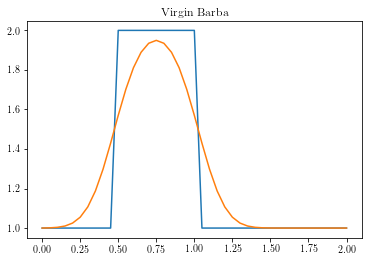

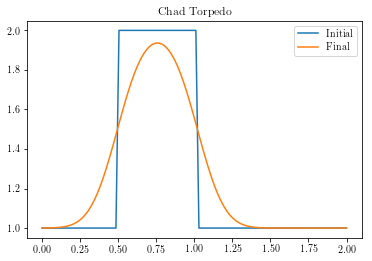

In [211]:
def diffusionequation(nx):
    dx = 2.0/(nx-1)
    nt = 20
    nu = 0.3
    sigma = 0.2
    dt = sigma*dx**2/nu
    
    u = numpy.ones(nx)
    u[int (.5/dx): int(1/dx + 1)] = 2.0
    print(u)

    pyplot.figure(1)
    pyplot.title('Virgin Barba')
    pyplot.plot(numpy.linspace(0,2,nx), u)

    for n in range(nt):
        un = u.copy()
        for i in range(1,nx - 1):
            u[i] = un[i] + nu*dt/dx**2*(un[i+1] - 2*un[i] + un[i-1] )

    pyplot.plot(numpy.linspace(0,2,nx), u)

diffusionequation(41)

# This version forces the Courant number to be 0.2 and calculates the timestep accordingly for "accurate" results.
def diffusionEquation(mesh_size, time):
    dx = 2.0/mesh_size
    nu = 0.3
    sigma_max = 0.2
    dt = sigma_max*dx**2/nu
    time_steps = int(time/dt)
    
    ## Initial condition definition
    u = numpy.ones((time_steps,mesh_size))
    u[0][int (.5/dx): int(1/dx + 1)] = 2.0
    print(u[0])

    for n in range(time_steps-1):
        for i in range(1,mesh_size - 1):
            u[n+1][i] = u[n][i] + nu*dt/dx**2*(u[n][i+1] - 2*u[n][i] + u[n][i-1])

    pyplot.figure(2)
    pyplot.title('Chad Torpedo')
    pyplot.plot(numpy.linspace(0,2,mesh_size), u[0], label='Initial')
    pyplot.plot(numpy.linspace(0,2,mesh_size), u[time_steps-1], label='Final')
    pyplot.legend()

diffusionEquation(100, 0.0333333)

### Step 4: Burgers' Equation

Partial differential equation: 

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2 u}{\partial x^2} $$

Discretised: $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} + u^n_i\frac{u^n_i - u^n_{i-1}}{\Delta x} = \nu\frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{\Delta x^2} $$

Initial conditions: 

$$ u(x,0) = -\frac{2\nu}{\phi}\frac{\partial\phi}{\partial x} + 4 $$

$$ \phi(x,0) = \exp\left(\frac{-x^2}{4\nu}\right) + \exp\left(\frac{-(x-2\pi)^2}{4\nu}\right) $$

Boundary condition: $$ u(0,t) = u(2\pi,t) $$

[4.         4.06283185 4.12566371 4.18849556 4.25132741 4.31415927
 4.37699112 4.43982297 4.50265482 4.56548668 4.62831853 4.69115038
 4.75398224 4.81681409 4.87964594 4.9424778  5.00530965 5.0681415
 5.13097336 5.19380521 5.25663706 5.31946891 5.38230077 5.44513262
 5.50796447 5.57079633 5.63362818 5.69646003 5.75929189 5.82212374
 5.88495559 5.94778745 6.0106193  6.07345115 6.136283   6.19911486
 6.26194671 6.32477856 6.38761042 6.45044227 6.51327412 6.57610598
 6.63893783 6.70176967 6.76460125 6.82742866 6.89018589 6.95176632
 6.99367964 6.72527549 4.         1.27472451 1.00632036 1.04823368
 1.10981411 1.17257134 1.23539875 1.29823033 1.36106217 1.42389402
 1.48672588 1.54955773 1.61238958 1.67522144 1.73805329 1.80088514
 1.863717   1.92654885 1.9893807  2.05221255 2.11504441 2.17787626
 2.24070811 2.30353997 2.36637182 2.42920367 2.49203553 2.55486738
 2.61769923 2.68053109 2.74336294 2.80619479 2.86902664 2.9318585
 2.99469035 3.0575222  3.12035406 3.18318591 3.24601776 3.308849

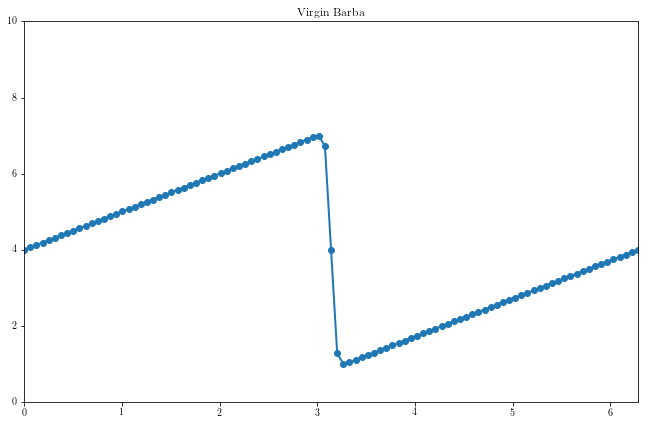

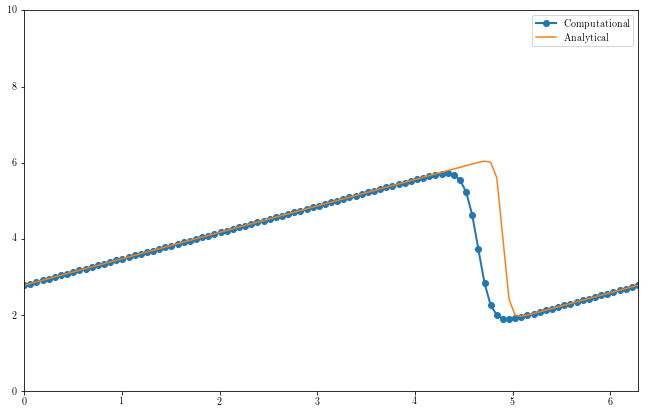

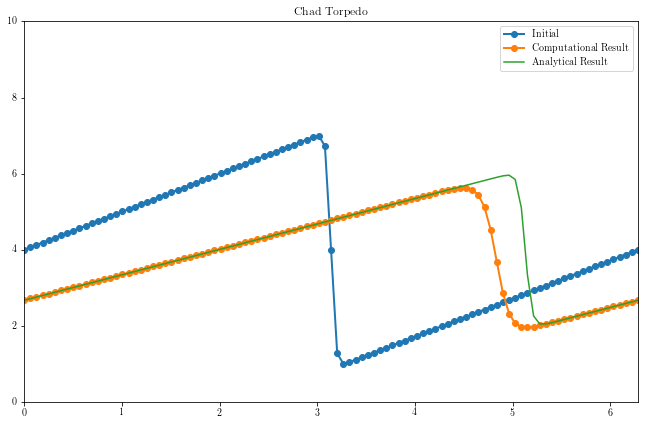

In [184]:
x, t, nu = sympy.symbols('x t nu')
phi = sympy.exp(-(x-4*t)**2/(4*nu*(t+1))) + sympy.exp(-(x-4*t-2*numpy.pi)**2/(4*nu*(t+1)))
diffphi = sympy.diff(phi, x)
u = -2*nu/phi*diffphi + 4
ufunc = sympy.lambdify((t,x,nu), u)

def burgersequation(nx):
    dx = 2.0*numpy.pi/(nx-1)
    nt = 100
    nu = 0.07
    dt = dx*nu
    
    x = numpy.linspace(0, 2*numpy.pi,nx)
    un = numpy.empty(nx)
    t = 0
    
    u = numpy.asarray([ufunc(t,x0,nu) for x0 in x])
    print(u)

    pyplot.figure(1,figsize=(11, 7))
    pyplot.title('Virgin Barba')
    pyplot.plot(x, u, marker='o', lw=2)
    pyplot.xlim([0, 2 * numpy.pi])
    pyplot.ylim([0, 10])

    for n in range(nt):
        un = u.copy()
        for i in range(1,nx-1):
            u[i] = un[i]*(1-dt/dx*(un[i] - un[i-1])) + nu*dt/dx**2*(un[i+1] - 2*un[i] + un[i-1])
        u[0] = un[0]*(1-dt/dx*(un[0] - un[-2])) + nu*dt/dx**2*(un[1] - 2*un[0] + un[-2])
        u[-1] = u[0]
    
    u_analytical = numpy.asarray([ufunc(nt*dt, xi, nu) for xi in x])
    
    pyplot.figure(2,figsize=(11, 7))
    pyplot.plot(x, u, marker='o', lw=2, label='Computational')
    pyplot.plot(x, u_analytical, label='Analytical')
    pyplot.xlim([0, 2 * numpy.pi])
    pyplot.ylim([0, 10])
    pyplot.legend()

burgersequation(101)

def burgersEquation(mesh_size, time):
    dx = 2.0*numpy.pi/(mesh_size-1)
    nu = 0.07
    dt = dx*nu
    timesteps = int(time/dt)
    
    x = numpy.linspace(0, 2*numpy.pi, mesh_size)
    u = numpy.empty((timesteps,mesh_size))
    
    u[0] = numpy.asarray([ufunc(0,x0,nu) for x0 in x])
    
    pyplot.figure(3,figsize=(11, 7))
    pyplot.title('Chad Torpedo')
    pyplot.plot(x, u[0], marker='o', lw=2, label = 'Initial')
    pyplot.xlim([0, 2*numpy.pi])
    pyplot.ylim([0, 10])
    
    for n in range(timesteps-1):
        for i in range(1,mesh_size-1):
            u[n+1][i] = u[n][i]*(1-dt/dx*(u[n][i] - u[n][i-1])) + nu*dt/dx**2*(u[n][i+1] - 2*u[n][i] + u[n][i-1]) 
            u[n+1][0] = u[n][0]*(1-dt/dx*(u[n][0] - u[n][-2])) + nu*dt/dx**2*(u[n][1] - 2*u[n][0] + u[n][-2])
            u[n+1][-1] = u[n+1][0]
            
    u_analytical = numpy.asarray([ufunc(timesteps*dt, xi, nu) for xi in x])
    
    pyplot.figure(3,figsize=(11, 7))
    pyplot.plot(x, u[timesteps-1], marker='o', lw=2, label='Computational Result')
    pyplot.plot(x, u_analytical, label='Analytical Result')
    pyplot.xlim([0, 2*numpy.pi])
    pyplot.ylim([0, 10])
    pyplot.legend()
    
burgersEquation(101,0.5)

### Aside: Kardar–Parisi–Zhang equation

The KPZ equation is a generalisation of Burgers' equation to multiple dimensions. Write Burgers' equation in the form:

$$ \frac{\partial u}{\partial t} + \frac{\partial u^2}{\partial x} = \nu\frac{\partial^2 u}{\partial x^2} $$

Let $ u = \psi_x $, then Burgers' equation becomes:

$$ \psi_{tx} + \psi_x\psi_{xx} = \nu\psi_{xxx} $$

$$ \partial_x\left(\psi_t + \frac{\psi_x^2}{2} \right) = \nu\partial_x(\psi_{xx}) $$ 

Integrating with respect to x gives the following equation:

$$ \frac{\partial \psi}{\partial t} + \frac{1}{2}\left(\frac{\partial \psi}{\partial x}\right)^2 = \nu\frac{\partial^2 \psi}{\partial x^2} $$

This is the KPZ equation in one dimension, which seemingly generalises to:

$$ \frac{\partial \psi}{\partial t} + \frac{\lambda}{2}\left(\nabla \psi\right)^2 = \nu\nabla^2 \psi $$

Whatever "$(\nabla \psi)^2$" means. Let $\lambda = 2$ and take the one-dimensional case, then the equation has an integrating factor (thanks to Vyn from freenode's `##math`!), which allows it to be written in the form of the 1-D diffusion equation:

$$ \frac{\partial}{\partial t}\left[\exp\left(-\frac{\psi}{\nu}\right)\right] = \nu\frac{\partial^2}{\partial x^2}\left[\exp\left(-\frac{\psi}{\nu}\right)\right] $$ 

TODO: Add solution.

### 2-D Linear Convection

Partial differential equation: $$ \frac{\partial u}{\partial t} + c\left(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial y} \right) = 0 $$

Discretised: $$ \frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} + c\left(\frac{u^n_{i,j} - u^n_{i-1,j}}{\Delta x} + \frac{u^n_{i,j} - u^n_{i,j-1}}{\Delta y}\right) = 0 $$`

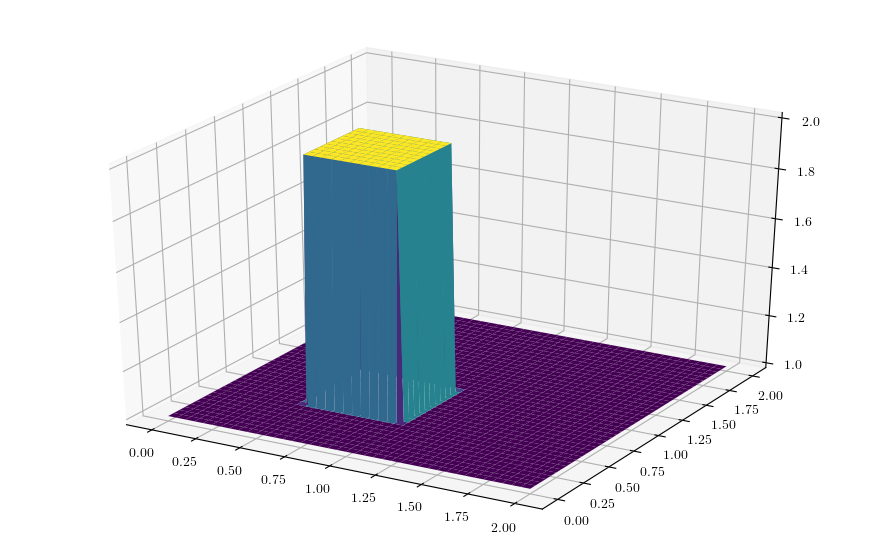

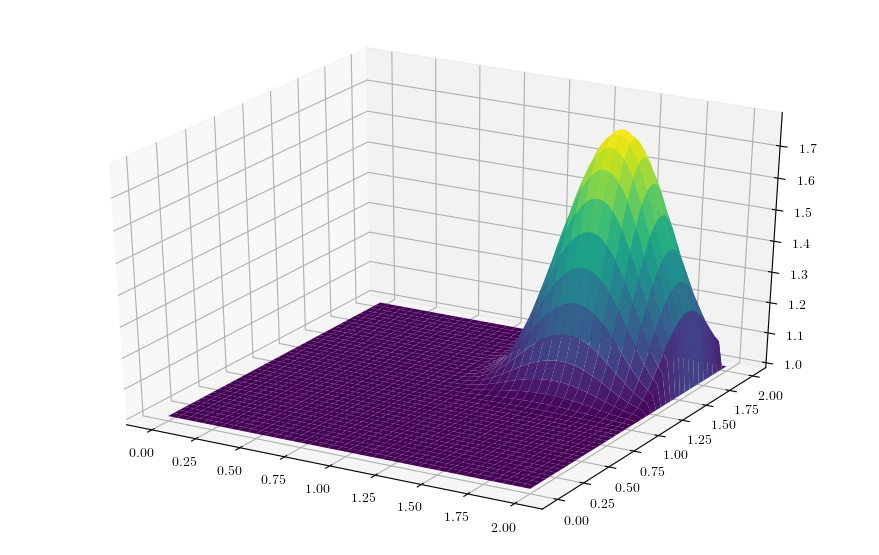

In [217]:
def linearconv2D(nx,ny):
    dx = 2.0/(nx - 1)
    dy = 2.0/(ny - 1)
    c = 1
    sigma = 0.2
    nt = 100
    dt = sigma*dx
    
    x = numpy.linspace(0, 2, nx)
    y = numpy.linspace(0, 2, ny)
    
    u = numpy.ones((ny,nx))
    un = numpy.ones((ny,nx))
    u[int(0.5/dy):int(1.0/dy + 1),int(.5/dx):int(1.0/dx + 1)] = 2 
    
    fig = pyplot.figure(1,figsize=(11,7),dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)
    
    for n in range(nt + 1):
        un = u.copy()
        row, col = u.shape
        for j in range(1, row):
            for i in range(1, col):
                u[j,i] = un[j,i] - c*dt*((u[j,i] - u[j,i-1])/dx + (u[j,i] - u[j-1,i])/dy)
                u[0,:] = 1
                u[-1,:] = 1
                u[:,0] = 1
                u[:,-1] = 1
    
    fig = pyplot.figure(2,figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)
    
linearconv2D(81,81)